# Issues in practice: lecture slides

<br><br><br><br><br>

## Which library to use?

**Many (canned) algorithms:**

<table>
    <tr style="background: white;">
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/0/05/Scikit_learn_logo_small.svg" style="height: 90px;"></td>
    </tr>
</table>

* Scikit-Learn's algorithms have a common interface, which makes it easy to learn a new one, but they're not flexible (only configurable by a long list of function arguments).

<br><br>

**Neural networks:**

<table>
    <tr style="background: white;">
        <td style="text-align: center; padding-right: 15px;"><img src="https://upload.wikimedia.org/wikipedia/commons/a/ab/TensorFlow_logo.svg" style="height: 140px;"></td>
        <td style="text-align: center; padding-left: 15px;"><img src="https://keras.io/img/logo.png" style="height: 60px;"></td>
    </tr> <tr style="background: white;">
        <td style="text-align: center; padding-right: 15px;"><img src="https://upload.wikimedia.org/wikipedia/commons/c/c6/PyTorch_logo_black.svg" style="height: 45px;"></td>
        <td style="text-align: center; padding-left: 15px;"><img src="https://raw.githubusercontent.com/valohai/ml-logos/master/mxnet.svg" style="height: 60px;"></td>
    </tr>
</table>

* TensorFlow and Keras merged, with Keras becoming the high-level interface to TensorFlow.
* TensorFlow tends to be associated more with industry and production environments; PyTorch tends to be associated more with academic research.
  * In PyTorch, the training loop (feeding the algorithm batches of data to fit) is just a Python for loop, which makes it easy to develop and debug.
  * In TensorFlow 2.0 (2019) and later, training can be done this way as well.
  * Both can be hard to install if you're trying to use a GPU (hard to match your CUDA library version).
* MXNet is much less popular than TensorFlow and PyTorch, and development ended recently (2023).

<br><br>

**Neural network-capable array library:**

<table>
    <tr style="background: white;">
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/8/86/Google_JAX_logo.svg" style="height: 75px;"></td>
    </tr>
</table>

* JAX is a NumPy replacement with support for GPU, autodiff, and JIT-compilation, which makes it possible to build new algorithms from scratch.
  * Same installation troubles with GPUs/CUDA.

<br><br>

**Boosted decision trees:**

<table>
    <tr style="background: white;">
        <td style="text-align: center; padding-right: 30px; padding-bottom: 25px;"><img src="https://upload.wikimedia.org/wikipedia/commons/6/69/XGBoost_logo.png" style="height: 60px;"></td>
        <td style="text-align: center;"><img src="https://upload.wikimedia.org/wikipedia/commons/d/d9/LightGBM_logo_black_text.svg" style="height: 45px;"></td>
        <td style="text-align: center; padding-left: 30px;"><img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/CatBoostLogo.png" style="height: 70px; vertical-align: middle; padding-bottom: 15px;"> <span style="font-size: 18pt;">CatBoost</span></td>
</table>

* Boosted decision trees are still relevant for problems with well-chosen input features.

<br><br><br><br><br>

### What does everyone else use?

Using techniques described [here](https://indico.jlab.org/event/459/contributions/11547/) and [here](https://github.com/jpivarski-talks/2023-05-09-chep23-analysis-of-physicists), this is the number of times each ML library is imported, semiannually, in code written by CMS physicists:

<img src="../img/github-ml-package-cmsswseed.svg" width="900">

* Scikit-Learn is oldest and still widely used
* TensorFlow is dominant (and used to be imported with Keras, but not so much anymore)
* PyTorch is increasingly significant
* XGBoost is also common
* JAX and the other libraries are not widely used

<br><br><br><br><br>

Using Google Trends (world search volume, not just physicists):

<img src="../img/google-ml-package.svg" width="900">

* PyTorch saw a burst of interest since 2023, but it's because of LLMs:

<img src="../img/google-ml-llm-package.svg" width="900">

* That's not relevant for HEP, though it would be interesting to extend my analysis of CMS physicsts one more year.

<br><br><br><br><br>

### What will this mini-course use?

Scikit-Learn for linear fits and simple neural networks.

PyTorch for neural network architectures, because it's easier to illustrate the parts.

<br><br>

Most of the examples in _this lesson_ are linear fits because the issues that I'll be discussing are general.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

import sklearn.linear_model
import torch
from torch import nn, optim

In [2]:
penguins_df = pd.read_csv("../data/penguins.csv")

In [3]:
boston_prices_df = pd.read_csv(
    "../data/boston-house-prices.csv", sep="\s+", header=None,
    names=["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"],
)
boston_prices_df = (boston_prices_df - boston_prices_df.mean()) / boston_prices_df.std()

In [23]:
stockmarket_data = [float(x) for x in open("../data/nasdaq-NXPI-20160726-to-20170428.csv")]

<br><br><br><br><br>

## Regression versus classification, loss functions

When we think of fitting, we usually think of regression:

In [ ]:
model = sklearn.linear_model.LinearRegression()
model.fit(penguins_df.dropna()["flipper_length_mm"].values[:, np.newaxis], penguins_df.dropna()["body_mass_g"])

model_x = np.linspace(170, 240, 2)
model_y = model.predict(model_x[:, np.newaxis])

fig, ax = plt.subplots()

penguins_df.plot.scatter("flipper_length_mm", "body_mass_g", ax=ax)
ax.plot(model_x, model_y, color="orange", linewidth=3)

None

Given $x$ values drawn from a vector space, the model responds with the most likely $y$ values, which also come from a vector space (that is, they're real-valued, maybe more than one of them).

<br><br><br><br><br>

Sometimes, though, you're interested in _categorical_ data, like the colors of the dots in the TensorFlow Playground exercise.

In general, there are [four levels of measurement](https://en.wikipedia.org/wiki/Level_of_measurement),

| Level | Math | Description | Physics example |
|:--|:--:|:--|:--|
| Nominal category | =, ≠ | categories without order | jet classification, data versus Monte Carlo |
| Ordinal category | >, < | categories that have an order | barrel region, overlap region, endcap region |
| Interval number | +, ‒ | doesn't have an origin | energy, voltage, position, momentum |
| Ratio number | ×, / | has an origin | absolute temperature, mass, opening angle |

But generally, we only need to be concerned about categorical versus numerical.

<br><br><br><br><br>

Suppose we have data from two distinct categories that have different, but overlapping, distributions.

In [ ]:
adelie_df = penguins_df[penguins_df["species"] == "Adelie"][["bill_length_mm", "bill_depth_mm"]].dropna()
gentoo_df = penguins_df[penguins_df["species"] == "Gentoo"][["bill_length_mm", "bill_depth_mm"]].dropna()

<img src="../img/culmen_depth.png" width="300">

In [ ]:
fig, ax = plt.subplots()

adelie_df["bill_depth_mm"].plot.hist(alpha=0.5)
gentoo_df["bill_depth_mm"].plot.hist(alpha=0.5)

ax.set_xlabel("Bill depth (mm)")

None

We can express the two categories as values 0 and 1 in a numeric dataset:

In [ ]:
species = np.concatenate([np.zeros(len(adelie_df)), np.ones(len(gentoo_df))])
bill_depth = np.concatenate([adelie_df["bill_depth_mm"].values, gentoo_df["bill_depth_mm"].values])

In [ ]:
fig, ax = plt.subplots()

ax.scatter(species, bill_depth, marker="x")

ax.set_xlabel("Species; 0 = Adelie, 1 = Gentoo")
ax.set_ylabel("Bill depth (mm)")
ax.set_xlim(-0.5, 1.5)

None

<br><br><br><br><br>

### Categorical → numerical and numerical → categorical

If we are intending to use the categorical data as a _feature_, an input to the model, then we can fit it as-is.

In [ ]:
model = sklearn.linear_model.LinearRegression()
model.fit(species[:, np.newaxis], bill_depth)

model_x = np.linspace(-0.5, 1.5, 2)
model_y = model.predict(model_x[:, np.newaxis])

fig, ax = plt.subplots()

ax.scatter(species, bill_depth, marker="x")
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.set_xlabel("Species; 0 = Adelie, 1 = Gentoo")
ax.set_ylabel("Bill depth (mm)")
ax.set_xlim(-0.5, 1.5)

None

The fit value at 0 is the average Adelie bill depth and the fit value at 1 is the average Gentoo bill depth.

But if the model is supposed to _predict_ the categorical data, as an output of the model, then a linear fit is not meaningful:

In [ ]:
model = sklearn.linear_model.LinearRegression()
model.fit(bill_depth[:, np.newaxis], species)

model_x = np.linspace(12, 22, 2)
model_y = model.predict(model_x[:, np.newaxis])

fig, ax = plt.subplots()

ax.scatter(bill_depth, species, marker="x")
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.set_xlabel("Bill depth (mm)")
ax.set_ylabel("Species; 0 = Adelie, 1 = Gentoo")

ax.text(18, 0.5, "WRONG!!!", color="red", size=22)

None

Whether the model is predicting an allowed species value of 0 or 1, an intermediate value like 0.5, or an out-of-bounds value like 1.5, it's not expressing anything that means anything to us.

Since a linear fit or neural network has to predict continuous numerical values, we can make them useful and interpret them as probabilities. In the training dataset, "0 = Adelie, 1 = Gentoo" can be interpreted as the probability of Gentoo.

The sigmoid function from the previous lecture,

$$ p(x) = \frac{1}{1 + \exp(x)} $$

clamps the output value of the model between 0 and 1, and a loss function of

<!--
$$ \mathcal{L}_k(x_i) = \left\{\begin{array}{l l}
-\log (p_k(x_i)) & \mbox{if species of } x_i \mbox{ is } k \\
-\log (1 - p_k(x_i)) & \mbox{if species of } x_i \mbox{ is not } k \\
\end{array}\right. $$
-->

$$ \mbox{loss}(x_i, y_i) = -(y_i) \log \big[ p(x_i) \big] - (1 - y_i) \log \big[ 1 - p(x_i) \big] $$

optimizes a linear model to predict probabilities $p(x_i)$ that match the given probabilities $y_i$.

In Scikit-Learn, this is

In [ ]:
model = sklearn.linear_model.LogisticRegression(penalty=None)
model.fit(bill_depth[:, np.newaxis], species)

model_x = np.linspace(12, 22, 1000)
model_y = model.predict_proba(model_x[:, np.newaxis])[:, 1]

fig, ax = plt.subplots()

ax.scatter(bill_depth, species, marker="x")
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.set_xlabel("Bill depth (mm)")
ax.set_ylabel("Probability that species is Gentoo")

None

<br><br><br><br><br>

### Classification in PyTorch

2 lines of code in Scikit-Learn becomes a class definition, 8 lines of initialization, and an explicit 5-line loop over training steps in PyTorch.

In [ ]:
# this user-defined model step centers and scales the input
# without this, the optimizer would require many more steps to find the minimum
class NormalizeInput(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor([mean], dtype=torch.float32))
        self.register_buffer("std", torch.tensor([std], dtype=torch.float32))
    def forward(self, x):
        return (x - self.mean) / self.std

normalize_input = NormalizeInput(bill_depth.mean(), bill_depth.std())

model = nn.Sequential(      # define a 3-step model
    normalize_input,        # step 1: center/scale the input
    nn.Linear(1, 1),        # step 2: linear transformation (1D → 1D)
    nn.Sigmoid(),           # step 3: pass output through a sigmoid
)

# convert the data into PyTorch Tensors, which are differentiable and can live on a GPU
features = torch.tensor(bill_depth[:, np.newaxis], dtype=torch.float32)
targets = torch.tensor(species[:, np.newaxis], dtype=torch.float32)

# use Binary Cross Entropy as a loss function
loss_function = nn.BCELoss()

# use Adam as an optimizer with a (high) learning rate of 0.03
optimizer = optim.Adam(model.parameters(), lr=0.03)

# iterate over the same data 1000 times (epochs)
for epoch in range(1000):
    # tell the optimizer to begin an optimization step
    optimizer.zero_grad()

    # give the model the input features and ask it to compute its predictions
    predictions = model(features)

    # compute the loss between these predictions and the intended targets
    loss = loss_function(predictions, targets)

    # tell the loss function and optimizer to end an optimization step
    loss.backward()
    optimizer.step()

In [ ]:
model_x = np.linspace(12, 22, 1000)
model_y = model(torch.tensor(model_x[:, np.newaxis], dtype=torch.float32)).detach().numpy()

fig, ax = plt.subplots()

ax.scatter(bill_depth, species, marker="x")
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.set_xlabel("Bill depth (mm)")
ax.set_ylabel("Probability that species is Gentoo")

None

<br><br><br><br><br>

PyTorch makes all of the steps explicit, and that's (eventually) a good thing because we can change any step of the process.

The steps that distinguish regression from classification are

* including [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) as the last step of the `model`
* using [nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) instead of [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) as the loss function.

See a full list of [PyTorch loss functions here](https://pytorch.org/docs/stable/nn.html#loss-functions).

<br><br>

(The `NormalizeInput` class is an example of a user-defined model step to center and scale the input. Without it, the fit would be much slower. If I pre-processed the data manually, I'd have to remember to apply the same pre-processing on the training and prediction data.)

<br><br><br><br><br>

In [ ]:
loss_function = nn.MSELoss()

In [ ]:
loss_function(torch.tensor([1.0]), torch.tensor([1.0]))

In [ ]:
loss_function(torch.tensor([2.0]), torch.tensor([1.0]))

In [ ]:
loss_function(torch.tensor([3.0]), torch.tensor([1.0]))

In [ ]:
loss_function(torch.tensor([4.0]), torch.tensor([1.0]))

<br><br><br><br><br>

In [ ]:
loss_function = nn.BCELoss()

In [ ]:
loss_function(torch.tensor([0.0001]), torch.tensor([1.0]))

In [ ]:
-np.log(0.0001)

In [ ]:
loss_function(torch.tensor([0.001]), torch.tensor([1.0]))

In [ ]:
loss_function(torch.tensor([0.01]), torch.tensor([1.0]))

In [ ]:
loss_function(torch.tensor([0.1]), torch.tensor([1.0]))

In [ ]:
loss_function(torch.tensor([0.5]), torch.tensor([1.0]))

In [ ]:
loss_function(torch.tensor([1.0]), torch.tensor([1.0]))

<br><br><br><br><br>

### More than two classes

Now suppose that we have more than two classes:

In [ ]:
adelie_df = penguins_df[penguins_df["species"] == "Adelie"][["bill_length_mm", "bill_depth_mm"]].dropna()
gentoo_df = penguins_df[penguins_df["species"] == "Gentoo"][["bill_length_mm", "bill_depth_mm"]].dropna()
chinstrap_df = penguins_df[penguins_df["species"] == "Chinstrap"][["bill_length_mm", "bill_depth_mm"]].dropna()

Can we define a species variable that takes values 0, 1, and 2?

In [ ]:
adelie_df["species"] = 0
gentoo_df["species"] = 1
chinstrap_df["species"] = 2

ordinal_df = pd.concat([adelie_df, gentoo_df, chinstrap_df])

model = sklearn.linear_model.LinearRegression()
model.fit(ordinal_df["species"].values[:, np.newaxis], ordinal_df["bill_depth_mm"].values)

model_x = np.linspace(-0.5, 2.5, 2)
model_y = model.predict(model_x[:, np.newaxis])

fig, ax = plt.subplots()

ordinal_df.plot.scatter("species", "bill_depth_mm", ax=ax)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.set_xlabel("Species; 0 = Adelie, 1 = Gentoo, 2 = Chinstrap")
ax.set_ylabel("Bill depth (mm)")

ax.text(0.5, 20, "WRONG!!!", color="red", size=22)

None

Unlike the case with only 2 values for species, the fit is now finding the _order_ and the _distances_ between the values 0, 1, and 2 to be meaningful: it's interpreting species as interval numbers, rather than nominal categories.

(With more parameters in the fit, we can wash away that interpretation: for instance, fitting the three categories with a parabola that goes through the mean of each. Neural networks with enough parameters can lose knowledge of the order and distances between integer encodings, so it can be okay in those contexts.)

<br><br><br><br><br>

Instead, expand a categorical variable with $n$ categories into $n$ variables whose values are 0 and 1:

In [ ]:
adelie_df["is_adelie"] = 1
gentoo_df["is_gentoo"] = 1
chinstrap_df["is_chinstrap"] = 1

onehot_df = pd.concat([adelie_df, gentoo_df, chinstrap_df]).fillna(0)
onehot_df

For historical reasons, this is called a [one-hot encoding](https://en.wikipedia.org/wiki/One-hot).

The three new features, `is_adelie`, `is_gentoo`, and `is_chinstrap`, can be interpreted as given probabilities, and therefore either 0 and 1. They're constrained to have `is_adelie + is_gentoo + is_chinstrap = 1`. In principle, we only need $n - 1$ variables, since one is determined by the others.

<br><br><br><br><br>

Here's a logistic regression in Scikit-Learn, using bill length and bill depth as 2 input features to predict 3 probabilities `is_adelie`, `is_gentoo`, `is_chinstrap`:

In [ ]:
features_np = onehot_df[["bill_length_mm", "bill_depth_mm"]].values
targets_np = onehot_df[["is_adelie", "is_gentoo", "is_chinstrap"]].values

In [ ]:
model = sklearn.linear_model.LogisticRegression(penalty=None)

# Scikit-Learn wants the target index, rather than the probability values themselves, so np.argmax
model.fit(features_np, np.argmax(targets_np, axis=1))

None

In [ ]:
fig, ax = plt.subplots()

# draw three scatter plots, each a different color
ax.scatter(features_np[targets_np[:, 0] == 1, 0], features_np[targets_np[:, 0] == 1, 1])
ax.scatter(features_np[targets_np[:, 1] == 1, 0], features_np[targets_np[:, 1] == 1, 1])
ax.scatter(features_np[targets_np[:, 2] == 1, 0], features_np[targets_np[:, 2] == 1, 1])

# compute the three probabilities for every 2D point in the background
background_x, background_y = np.meshgrid(np.linspace(29, 62, 100), np.linspace(12, 23, 100))
background_2d = np.column_stack([background_x.ravel(), background_y.ravel()])
probabilities = model.predict_proba(background_2d)

# draw contour lines where the probabilities cross the 50% threshold
ax.contour(background_x, background_y, probabilities[:, 0].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 1].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 2].reshape(background_x.shape), [0.5])

ax.set_xlabel("Bill length (mm)")
ax.set_ylabel("Bill depth (mm)")
ax.axis([29, 62, 12, 23])

ax.legend(["Adelie", "Gentoo", "Chinstrap"])

None

<br><br><br><br><br>

### 5-minute exercise: do a logistic regression of 2 features to 3 categories in PyTorch

Uncomment and run the debugging code if it's helpful to do so.

Remember: examine all your variables and look at each step! That's why we're using Python (and Jupyter) in the first place!

In [ ]:
features = torch.tensor(features_np, dtype=torch.float32)
targets = torch.tensor(targets_np, dtype=torch.float32)

In [ ]:
# features

In [ ]:
# targets

In [ ]:
class NormalizeInput(nn.Module):
    def __init__(self, mean1, std1, mean2, std2):
        super().__init__()
        self.register_buffer("mean", torch.tensor([mean1, mean2], dtype=torch.float32))
        self.register_buffer("std", torch.tensor([std1, std2], dtype=torch.float32))
    def forward(self, x):
        return (x - self.mean) / self.std

normalize_input = NormalizeInput(
    features_np[:, 0].mean(), features_np[:, 0].std(),
    features_np[:, 1].mean(), features_np[:, 1].std(),
)
# normalize_input.forward(features)

The softmax function is defined as:

$$ \mbox{softmax}_i(x) = \frac{\exp(x_i)}{\sum_j \exp(x_j)} $$

Consequentially,

$$ \sum_i \mbox{softmax}_i(x) = 1 $$

When we had only 2 categories, we could focus on only one of them and compute its sigmoid.

With 3 categories, we use the softmax to ensure that the model's output probabilities add to 1.

In [ ]:
model_without_softmax = nn.Sequential(
    normalize_input,
    nn.Linear(2, 3),
)
# model_without_softmax

In [ ]:
# model_without_softmax(features)

In [ ]:
model_with_softmax = nn.Sequential(
    model_without_softmax,
    nn.Softmax(dim=1),
)
# model_with_softmax

In [ ]:
# model_with_softmax(features)

In the next cell, define a `loss_function`, an `optimizer`, and implement the fit.

Use PyTorch's [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), which internally includes the softmax. Don't apply it twice!

The next cell plots the fit, just like Scikit-Learn, using the model with the softmax (because we need to plot probabilities).

In [ ]:
fig, ax = plt.subplots()

# draw three scatter plots, each a different color
ax.scatter(features_np[targets_np[:, 0] == 1, 0], features_np[targets_np[:, 0] == 1, 1])
ax.scatter(features_np[targets_np[:, 1] == 1, 0], features_np[targets_np[:, 1] == 1, 1])
ax.scatter(features_np[targets_np[:, 2] == 1, 0], features_np[targets_np[:, 2] == 1, 1])

# compute the three probabilities for every 2D point in the background
background_x, background_y = np.meshgrid(np.linspace(29, 62, 100), np.linspace(12, 23, 100))
background_2d = np.column_stack([background_x.ravel(), background_y.ravel()])
probabilities = model_with_softmax(torch.tensor(background_2d, dtype=torch.float32)).detach().numpy()

# draw contour lines where the probabilities cross the 50% threshold
ax.contour(background_x, background_y, probabilities[:, 0].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 1].reshape(background_x.shape), [0.5])
ax.contour(background_x, background_y, probabilities[:, 2].reshape(background_x.shape), [0.5])

ax.set_xlabel("Bill length (mm)")
ax.set_ylabel("Bill depth (mm)")
ax.axis([29, 62, 12, 23])

ax.legend(["Adelie", "Gentoo", "Chinstrap"])

None

<br><br><br><br><br>

## Optimizers: learning rate, epochs, mini-batches

Since neural networks rely so heavily on function minimization, this topic has been heavily researched.

PyTorch has a large set of [optimization algorithms](https://pytorch.org/docs/stable/optim.html) and recommendations. [So does TensorFlow.](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)

Generally, [Adam or AdamW is the best choice](https://www.fast.ai/posts/2018-07-02-adam-weight-decay.html), but you need to know how to parameterize it. The most important considerations are below.

1. The learning rate (`lr`): how large of a step size should the optimizer take? If it's too large, it can overshoot the minimum, and if it's too small, it will need more steps ("epochs") to reach the minimum.
2. Number of epochs (usually a `for` loop you write, but some algorithms take the body of the loop as a `closure` function it choose when to call it).
3. Number of mini-batches per epoch (also a `for` loop). I'll discuss this later.
4. Some algorithms use first-order derivatives of the loss function (computed automatically by calling `loss.backward()`).
5. Some algorithms have a configurable momentum (`betas`) that increase or decrease the step size. [This is a great explanation of the concept.](https://distill.pub/2017/momentum/)
6. The initial parameter values matter, too. (Fixing a problem in initial values contributed to the current boom in deep learning.) This can be controlled with initializers from [nn.init](https://pytorch.org/docs/master/nn.init.html), but the default for a linear layer of $n$ inputs is uniform in

$$ -\frac{1}{\sqrt{n}} < \mbox{initial weight} < \frac{1}{\sqrt{n}} $$

7. Flat sections of activation functions: if an input value to a sigmoid function is far from zero, the derivative is small and the optimizer won't know which direction to go. ("Vanishing gradients": also a problem whose solution contributed to the current boom in deep learning.)

<table>
    <tr style="background: white;"><td style="text-align: center;">Sigmoid (logistic)</td></tr>
    <tr style="background: white;"><td style="text-align: center;"><img src="../img/Activation_logistic.svg" width="200"></td></tr>
</table>

The ReLU, Leaky ReLU, and Swish functions solve this in different ways. (ReLU is the most common.)

<table>
    <tr style="background: white;"><td style="text-align: center;">ReLU</td><td style="text-align: center;">Leaky ReLU</td><td style="text-align: center;">Swish</td></tr>
    <tr style="background: white;"><td style="text-align: center;"><img src="../img/Activation_rectified_linear.svg" width="200"></td><td style="text-align: center;"><img src="../img/Activation_prelu.svg" width="200"></td><td style="text-align: center;"><img src="../img/Activation_swish.svg" width="200"></td></tr>
</table>

<br><br><br><br><br>

### 5-minute exercise: optimize a 2D function

To get some intuition about the optimization algorithms, try to find the minimum of the [Beale function](https://www.sfu.ca/~ssurjano/beale.html).

The true minimum of this function is at (3, 0.5) and has a value of 0.

(Note: this is not something you'd normally do, since most models have thousands of parameters and can't be visualized. The purpose of this exercise is to help you get a sense of what the parameters mean.)

In [ ]:
def beale(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

# a PyTorch "model" that just consists of two optimizable parameters
class Position2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.xy = nn.Parameter(torch.tensor([-1, 2], dtype=torch.float32, requires_grad=True))
    def forward(self):
        return self.xy[0], self.xy[1]

Define a optimizer than can find the true minimum of (3, 0.5), replacing the naive one in this cell:

In [ ]:
model = Position2D()

optimizer = optim.Adam(model.parameters(), lr=0.1)

In [ ]:
path_start = list(model.parameters())[0].detach().numpy().tolist()

path = [path_start]
for epoch in range(1000):

    # start an optimization step in the usual way
    optimizer.zero_grad()

    # this model has no arguments, and its loss function is beale (unusual!)
    loss = beale(*model())

    # finish an optimization step in the usual way
    loss.backward()
    optimizer.step()

    # keep track of the path, to plot it
    path.append(list(model.parameters())[0].detach().numpy().tolist())

path_np = np.array(path)

print("Final position, should be (3, 0.5):")
print(list(model.parameters())[0])
print()
print("Final loss, should be 0:")
print(loss)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

background_x, background_y = np.meshgrid(np.linspace(-4.5, 4.5, 1000), np.linspace(-4.5, 4.5, 1000))
contours = ax.contour(background_x, background_y, beale(background_x, background_y), [1, 3, 5, 10, 30, 50, 100, 300, 500, 1000], norm="log")
ax.clabel(contours, contours.levels)
ax.axis([-4.5, 4.5, -4.5, 4.5])

ax.scatter([3], [0.5], marker="*", s=1000, c="red")
ax.scatter([path_start[0]], [path_start[1]], marker="o", s=300, c="red")
ax.plot(path_np[:, 0], path_np[:, 1], c="red")

None

<br><br><br><br><br>

### Epochs and mini-batches

These aspects of optimization are under your control because you write the loops.

We've seen "epochs" before: it is the main optimizer loop.

Whereas Minuit iterates until it converges, most neural networks are iterated a large, fixed number of times. But since we have control, we can implement that:

In [ ]:
model = Position2D()

optimizer = optim.Adam(model.parameters(), lr=0.1)

Keep going until no input parameter changes by no more than 0.001.

In [ ]:
last_parameters = None
this_parameters = None

epoch = 0
while last_parameters is None or np.max(abs(this_parameters - last_parameters)) > 0.001:
    epoch += 1
    last_parameters = this_parameters

    optimizer.zero_grad()

    loss = beale(*model())

    loss.backward()
    optimizer.step()

    this_parameters = list(model.parameters())[0].detach().numpy().copy()

In [ ]:
epoch

(We could also have stopped when the change in `loss` is smaller than some threshold.)

<br><br><br><br><br>

Mini-batches are loops within the loop over epochs:

```python
for epoch in range(NUMBER_OF_EPOCHS):

    for batch_start in range(0, len(dataset), BATCH_SIZE):

        data_subset = dataset[batch_start : batch_start + BATCH_SIZE]
        optimization_step(data_subset)
```

<br><br>

Why would you do that?

Here's an illustration, using a linear fit for Boston housing prices:

In [ ]:
features = torch.tensor(boston_prices_df.drop(columns="MEDV").values).float()
targets = torch.tensor(boston_prices_df["MEDV"]).float()[:, np.newaxis]

In [ ]:
len(features)

In [ ]:
torch.manual_seed(12345)

model = nn.Linear(features.shape[1], 1)

loss_function = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.003)

loss_vs_epoch = []
for epoch in range(300):

    optimizer.zero_grad()
    predictions = model(features)
    loss = loss_function(predictions, targets)
    loss.backward()
    optimizer.step()

    loss_vs_epoch.append(loss.item() * len(features))

fig, ax = plt.subplots()

ax.plot(range(len(loss_vs_epoch)), loss_vs_epoch)

ax.set_xlabel("epoch number")
ax.set_ylabel("loss × number of features")

None

In [ ]:
torch.manual_seed(12345)

model = nn.Linear(features.shape[1], 1)

loss_function_batched = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.003)

loss_vs_epoch_batched = []
for epoch in range(300):
    total_loss = 0

    BATCH_SIZE = 100
    for batch_start in range(0, len(features), BATCH_SIZE):
        batch_stop = batch_start + BATCH_SIZE

        features_subset = features[batch_start:batch_stop]
        targets_subset = targets[batch_start:batch_stop]

        optimizer.zero_grad()
        predictions = model(features_subset)
        loss = loss_function(predictions, targets_subset)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(features_subset)

    loss_vs_epoch_batched.append(total_loss)

fig, ax = plt.subplots()

ax.plot(range(len(loss_vs_epoch)), loss_vs_epoch)
ax.plot(range(len(loss_vs_epoch_batched)), loss_vs_epoch_batched)

ax.set_xlabel("epoch number")
ax.set_ylabel("loss × number of features")
ax.legend(["one big batch", f"mini-batches of size {BATCH_SIZE}"])

None

<br><br><br><br><br>

Convergence is faster, but why?

Mini-batches are a compromise between two extremes:

* Batch gradient descent (e.g. Minuit), which uses the whole dataset in each optimizer update. It can get caught in saddle points and long, narrow valleys.
* Stochastic gradient descent, which updates the model with each input data point. It can be noisy.

<img src="../img/why-mini-batches.png" width="600">

<br><br><br><br><br>

Mini-batches don't need to be contiguous in the input data, and it's sometimes better if they're not.

What would happen if this dataset was mini-batched?

In [ ]:
fig, ax = plt.subplots()

ax.plot(range(len(stockmarket_data)), stockmarket_data)

ax.set_xlabel("minutes after July 26, 2016")
ax.set_ylabel("NASDAQ value of NXPI")

None

<br><br><br><br><br>

PyTorch has as [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html) to split a dataset into batches consistently, and optionally shuffle it to remove time-series correlations.

The TensorFlow equivalent is [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) (see the [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) methods).

<br><br><br><br><br>

## Feature selection and the "kernel trick"

As you saw in the TensorFlow Playground, non-linear combinations of input features can be as good as or better than adding hidden layers.

<img src="../img/playground-feature-selection.png" width="200">

Adding these features allows a linear classifier to solve (some!) non-linear problems.

This method was popularized for Support Vector Machines (SVMs), but it applies to any linear classifier, including a neural network layer.

<br><br><br><br><br>

Demonstrate with the "circle" problem from TensorFlow Playground:

In [4]:
inner_r = abs(np.random.normal(0, 1, 1000))
outer_r = abs(np.random.normal(3, 0.5, 1000))
inner_phi = np.random.uniform(0, 2*np.pi, 1000)
outer_phi = np.random.uniform(0, 2*np.pi, 1000)

inner_x = inner_r * np.cos(inner_phi)
inner_y = inner_r * np.sin(inner_phi)
outer_x = outer_r * np.cos(outer_phi)
outer_y = outer_r * np.sin(outer_phi)

all_x = np.concatenate([inner_x, outer_x])
all_y = np.concatenate([inner_y, outer_y])
targets = np.concatenate([np.zeros(1000), np.ones(1000)])

In [5]:
features_2d = np.column_stack([all_x, all_y])
features_2d

array([[ 0.07468127,  1.07346839],
       [-0.52600505,  0.11158316],
       [-0.4759805 ,  0.63586433],
       ...,
       [-2.40011474,  1.04944189],
       [-2.30522624,  3.25603698],
       [ 0.4571241 , -2.61481931]])

Linear classification can't find the decision boundary in 2 dimensions.

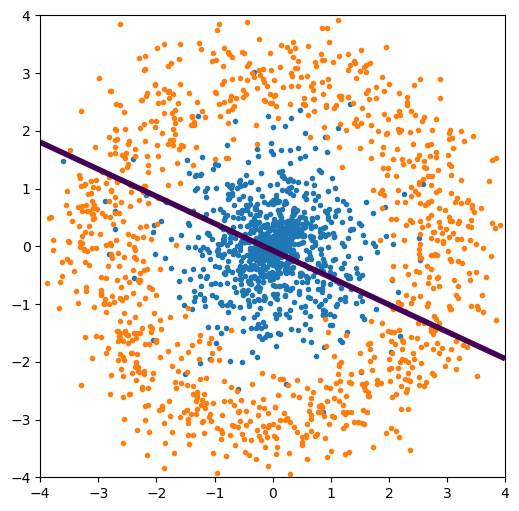

In [6]:
model = sklearn.linear_model.LogisticRegression(penalty=None)

model.fit(features_2d, targets)

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(inner_x, inner_y, marker=".")
ax.scatter(outer_x, outer_y, marker=".")

background_x, background_y = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
background_2d = np.column_stack([background_x.ravel(), background_y.ravel()])
probabilities = model.predict_proba(background_2d)

ax.contour(background_x, background_y, probabilities[:, 0].reshape(background_x.shape), [0.5], linewidths=[4])

ax.axis([-4, 4, -4, 4])

None

But if the third input feature is $x^2 + y^2$,

In [7]:
features_3d = np.column_stack([all_x, all_y, all_x**2 + all_y**2])
features_3d

array([[ 0.07468127,  1.07346839,  1.15791168],
       [-0.52600505,  0.11158316,  0.28913211],
       [-0.4759805 ,  0.63586433,  0.63088088],
       ...,
       [-2.40011474,  1.04944189,  6.86187904],
       [-2.30522624,  3.25603698, 15.91584479],
       [ 0.4571241 , -2.61481931,  7.04624249]])

Linear classification can find the decision boundary in these 3 dimensions.

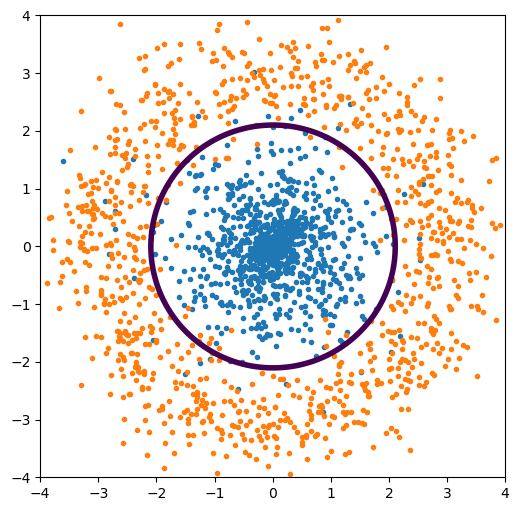

In [22]:
model = sklearn.linear_model.LogisticRegression(penalty=None)

model.fit(features_3d, targets)

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(inner_x, inner_y, marker=".")
ax.scatter(outer_x, outer_y, marker=".")

background_x, background_y = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
background_x2y2 = background_x**2 + background_y**2
background_3d = np.column_stack([background_x.ravel(), background_y.ravel(), background_x2y2.ravel()])
probabilities = model.predict_proba(background_3d)

ax.contour(background_x, background_y, probabilities[:, 0].reshape(background_x.shape), [0.5], linewidths=[4])

ax.axis([-4, 4, -4, 4])

None

Because this third dimension separates the points in a way that can be sliced with a linear (planar) boundary.

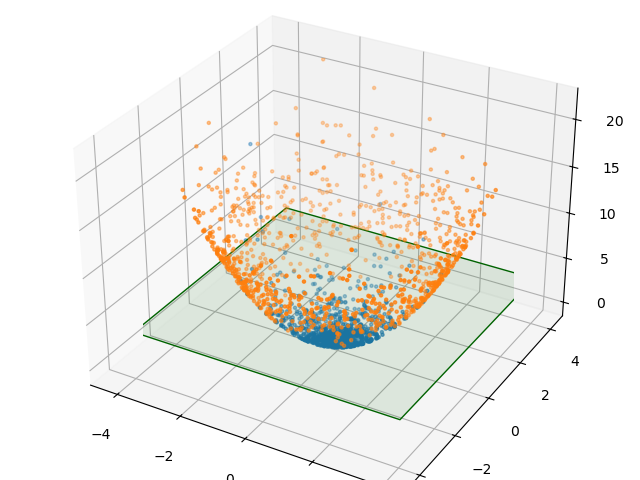

In [19]:
%matplotlib widget

fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect(None, zoom=1.5)

ax.scatter(features_3d[targets == 0, 0], features_3d[targets == 0, 1], zs=features_3d[targets == 0, 2], marker=".")
ax.scatter(features_3d[targets == 1, 0], features_3d[targets == 1, 1], zs=features_3d[targets == 1, 2], marker=".")

background_x, background_y = np.meshgrid(np.linspace(-4, 4, 2), np.linspace(-4, 4, 2))
ax.plot_surface(background_x, background_y, np.full_like(background_x, 3.63636364), facecolors=["green"], alpha=0.1)

None

In [20]:
%matplotlib inline

<br><br><br><br><br>

This is why Taylor and Fourier series are a kind of linear fitting: even a single feature $x$ can be used as an $n$-dimensional space of $x$, $x^2$, $x^3$, ... $x^n$ (or similarly for $\sin x$, $\cos x$, $\sin 2x$, $\cos 2x$, etc.).

In [46]:
just_increasing_numbers = np.linspace(0, 1, len(stockmarket_data))[:, np.newaxis]
just_increasing_numbers

array([[0.00000000e+00],
       [2.46554402e-05],
       [4.93108804e-05],
       ...,
       [9.99950689e-01],
       [9.99975345e-01],
       [1.00000000e+00]])

In [47]:
polynomial_features = np.hstack([just_increasing_numbers**i for i in range(1, 30)])
polynomial_features

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [2.46554402e-005, 6.07890733e-010, 1.49878136e-014, ...,
        3.81631799e-125, 9.40930000e-130, 2.31990434e-134],
       [4.93108804e-005, 2.43156293e-009, 1.19902509e-013, ...,
        5.12217529e-117, 2.52578974e-121, 1.24548916e-125],
       ...,
       [9.99950689e-001, 9.99901381e-001, 9.99852075e-001, ...,
        9.98669459e-001, 9.98620214e-001, 9.98570971e-001],
       [9.99975345e-001, 9.99950690e-001, 9.99926036e-001, ...,
        9.99334516e-001, 9.99309877e-001, 9.99285239e-001],
       [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000]])

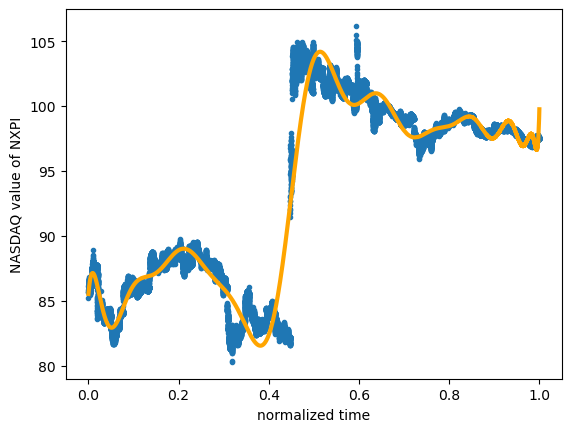

In [49]:
model = sklearn.linear_model.LinearRegression()

model.fit(polynomial_features, np.array(stockmarket_data))

model_y = model.predict(polynomial_features)

fig, ax = plt.subplots()

ax.scatter(just_increasing_numbers, stockmarket_data, marker=".")
ax.plot(just_increasing_numbers, model_y, color="orange", linewidth=3)

ax.set_xlabel("normalized time")
ax.set_ylabel("NASDAQ value of NXPI")

None

<br><br><br><br><br>

"Engineering" features can be useful if you know what's relevant to the problem (such as the circle).

If you don't, it's better to let hidden layers (adaptive basis functions) discover the features for you.

<br><br><br><br><br>

## Under & overfitting

What do you think of this fit?

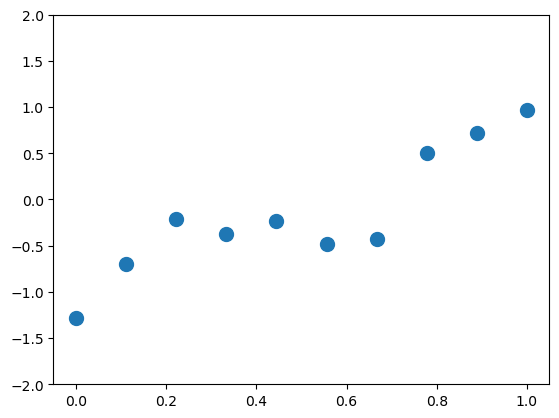

In [72]:
data_x = np.linspace(0, 1, 10)
data_y = -1 + 2*data_x + np.random.normal(0, 0.3, 10)

fig, ax = plt.subplots()

ax.scatter(data_x, data_y, s=100)

ax.set_ylim(-2, 2)

None

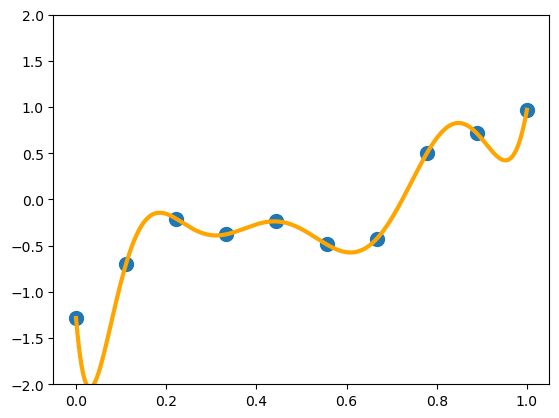

In [73]:
model = sklearn.linear_model.LinearRegression()
model.fit(np.hstack([data_x[:, np.newaxis]**i for i in range(1, 10)]), data_y[:, np.newaxis])

model_x = np.linspace(0, 1, 1000)
model_y = model.predict(np.hstack([model_x[:, np.newaxis]**i for i in range(1, 10)]))

fig, ax = plt.subplots()

ax.scatter(data_x, data_y, s=100)
ax.plot(model_x, model_y, color="orange", linewidth=3)

ax.set_ylim(-2, 2)

None

<br><br><br><br><br>

## Regularization: L1, L2, dropout

<br><br><br><br><br>

## Parameters versus hyperparameters

<br><br><br><br><br>

## Partitioning data into train-test-validate

<br><br><br><br><br>

## Goodness of fit metrics